In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
from numba import njit, prange

from matplotlib import pyplot as plt

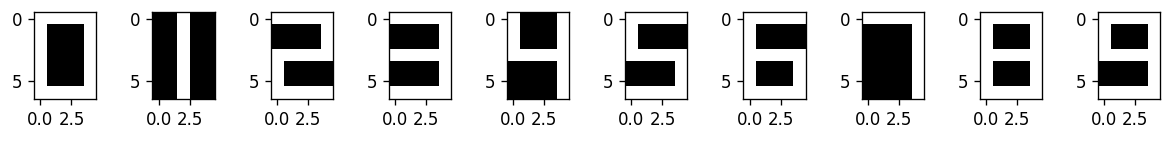

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_figwidth(10)
fig.set_dpi(120)

nums_mtrx = np.loadtxt(Path(r'D:/Development/Data/datasets/txt/numbers_7x5.txt'))

for n, ax in zip(nums_mtrx, axes.ravel()):
    ax.imshow(n.reshape(7, 5), cmap='gray')

plt.tight_layout()
plt.show()

In [5]:
cells_columns = [f'c{n}' for n in range(35)]
classes = ['zero', 'one', 'two', 'three', 'four',
           'five', 'six', 'seven', 'eight', 'nine']

df = pd.DataFrame(columns=cells_columns+['class'])

for i in range(10):
    new_row = dict(zip(cells_columns, nums_mtrx[i]))
    new_row['class'] = classes[i]

    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = nums_mtrx[i] + np.random.uniform(0, 0.5, 35)

        new_row = dict(zip(cells_columns, noised_num))
        new_row['class'] = classes[i]

        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

In [6]:
test_frac = 0.1

p = np.arange(10)

test_size = int(p.size*test_frac)
train_size = int(p.size*(1-test_frac))

idx_test = np.ravel([(p[0: test_size] + i*10) for i in range(10)])
idx_train = np.ravel([(p[test_size: p.size] + i*10) for i in range(10)])

features_columns = cells_columns
label_columns = [f"{name}_label" for name in classes]

xTest = np.array(df.iloc[idx_test][features_columns])
yTest = np.array(df.iloc[idx_test][label_columns])

xTrain = np.array(df.iloc[idx_train][features_columns])
yTrain = np.array(df.iloc[idx_train][label_columns])

In [7]:
@njit(fastmath=True)
def ident(x: np.ndarray) -> np.ndarray:
    return x


@njit(fastmath=True)
def dIdent(x: np.ndarray) -> np.ndarray:
    return np.ones(x.shape)


@njit(fastmath=True)
def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dRelu(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def tanh(x: np.ndarray) -> np.ndarray:
    return np.tanh(x)


@njit(fastmath=True)
def dTanh(x: np.ndarray) -> np.ndarray:
    return 1-np.square(np.tanh(x))


@njit(fastmath=True)
def bell(x: np.ndarray) -> np.ndarray:
    return np.exp(-np.square(x))


@njit(fastmath=True)
def dBell(x: np.ndarray) -> np.ndarray:
    return -2 * x * np.exp(-np.square(x))


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1/(1+np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1/(1+np.exp(-x))
    return y*(1-y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y/np.sum(y)

In [8]:
@njit(fastmath=True)
def grads(xBatch: np.ndarray, yBatch: np.ndarray, Wh: np.ndarray, w: np.ndarray, Bh: np.ndarray, Bz: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dWh = np.zeros(Wh.shape)
    dw = np.zeros(w.shape)

    dBh = np.zeros(Bh.shape)
    dBz = np.zeros(Bz.shape)
    db = np.zeros(b.shape)

    for i in prange(xBatch.shape[0]):
        h = Wh @ xBatch[i] + Bh
        z = sigmoid(Wh.T @ h + Bz)
        y = softmax(w @ z + b)

        dLdz = w.T @ (y-yBatch[i]) * z*(1-z)

        dw += np.outer(y-yBatch[i], z)
        db += y-yBatch[i]

        dWh += np.outer(Wh @ dLdz, xBatch[i])
        dBh += Wh @ dLdz
        dBz += dLdz

    return (dWh, dw, dBh, dBz, db)


class RBMPerceptron:
    def __init__(self, nH: int, nIn: int, nOut: int) -> None:
        self.nH = nH
        self.nIn = nIn
        self.nOut = nOut

        self.Wh: np.ndarray = np.random.uniform(-1, 1, (nH, nIn))
        self.w: np.ndarray = np.random.uniform(-1, 1, (nOut, nIn))

        self.Bh: np.ndarray = np.zeros(nH)
        self.Bz: np.ndarray = np.zeros(nIn)
        self.b: np.ndarray = np.zeros(nOut)

    def predict(self, x: np.ndarray) -> np.ndarray:
        h = self.Wh @ x + self.Bh
        z = sigmoid(self.Wh.T @ h + self.Bz)
        return softmax(self.w @ z + self.b)

    def train(self, xTrain: np.ndarray, yTrain: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = xTrain.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.choice(a=np.arange(n), size=batch_size, replace=False)

            for batch_idx in range(n//batch_size):
                ibegin, iend = batch_idx * batch_size, min((batch_idx+1)*batch_size, n-1)
                batch_idxs = idxs[ibegin:iend]

                dWh, dw, dBh, dBz, db = grads(
                    xTrain[batch_idxs], yTrain[batch_idxs], self.Wh, self.w, self.Bh, self.Bz, self.b)

                self.Wh -= lr*dWh
                self.w -= lr*dw

                self.Bh -= lr*dBh
                self.Bz -= lr*dBz
                self.b -= lr*db

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        yPred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y*np.log(yPred), axis=1)
        return np.mean(h)

In [25]:
nH = 70
nIn = 35
nOut = 10

lr = 1e-1
batch_size = 4
max_epoch = 1000

model = RBMPerceptron(nH, nIn, nOut)

print('untrained loss: {0:.6f}'.format(model.loss(xTest, yTest)))

model.train(xTrain, yTrain, lr, batch_size, max_epoch)

print('trained loss: {0:.6f}'.format(model.loss(xTest, yTest)))

TP_count = 0
for x, y in zip(xTest, yTest):
    yPred = model.predict(x)
    TP_count += 1 if np.argmax(y) == np.argmax(yPred) else 0

accuracy = TP_count / xTest.shape[0]
print(f"test set accuracy: {round(accuracy*100, 2)}%")

untrained loss: 0.733060
trained loss: 0.003134
test set accuracy: 100.0%


In [27]:
n_samples = 10000
noise_size = 1.0

TP_count = 0

for i in range(n_samples):
    j = i%10
    x = nums_mtrx[j] + np.random.uniform(0, noise_size, 35)
    yPred = model.predict(x)
    TP_count += 1 if j == np.argmax(yPred) else 0

print(f"accuracy: {round(TP_count/n_samples*100, 2)}% ({TP_count} of {n_samples})")

accuracy: 90.44% (9044 of 10000)


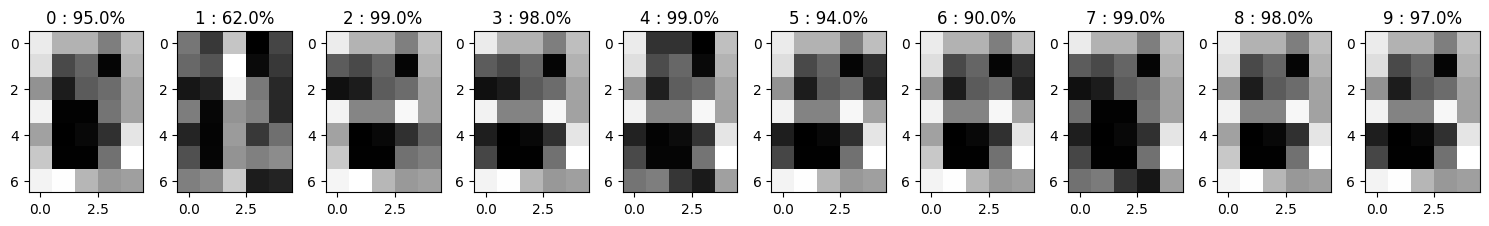

In [29]:
noise_size = 1.0
x_noised = nums_mtrx + np.random.uniform(0, noise_size, 35)

yPred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape((7, 5)),  cmap='gray')
    j = np.argmax(yPred[i])
    ax.set_title(f"{j} : {(yPred[i][j]*100).round()}%")

plt.autoscale()
plt.tight_layout()
plt.show()